# XGBoost Regression 목차

## 0. 분석 환경 확인

## 1. 패키지 로드

## 2. 데이터 로드

## 3. 분포 확인 및 이상치 제거

## 4. 데이터 분할

## 5. 정규화 및 라벨 인코딩

## 6. 모델 적용

### 6.1 초기 모델 적용

### 6.2 파라마터 튜닝-1

### 6.3 파리미터 튜닝-2

## 7. 결과 활용 및 해석

## 0.분석 환경 확인

In [4]:
import os
import random
import numpy as np
#현재 디렉토리 확인
print(os.getcwd())
# 분석 디렉토리로 이동
os.chdir('C:\\Users\\user\\Desktop\\법무부_파이썬분석\\시연관련데이터')
print(os.getcwd())

#시드고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

C:\Users\user\Desktop\법무부_파이썬분석\시연관련데이터
C:\Users\user\Desktop\법무부_파이썬분석\시연관련데이터


# MAE & mse & Rmse & Rmspe

- MAE=실제값과 예측값 사이의 절대값의 평균=> 크면 클 수록 예측력이 낮은 것
- MSE=실제값과 예측값 사이의 차이를 제곱한 평균
- RMSE=MSE에 루트를 취한 값
- RMSPE=예측 오차를 실제값으로 나눈후 제곱하여 평균을 측정한 제곱근임

In [5]:
# # MAE
# def Evaluation_metric(actual,pred):
#     print(f'MAE: {round(mean_absolute_error(actual,pred),2)}')
#     print(f'MSE: {round(mean_squared_error(actual,pred),2)}')
#     print(f'RMSE: {round(sqrt(mean_squared_error(actual,pred)),2)}')
#     print(f'RMSPE: {round(sqrt(mean_squared_error(actual,pred))/np.mean(actual)*100,2)}%')

In [6]:
# 성능지표 추출
def Evaluation_metric(actual,pred):
    print(f'MAE: {round(mean_absolute_error(actual,pred),2)}')
    print(f'MSE: {round(mean_squared_error(actual,pred),2)}')
    print(f'RMSE: {round(sqrt(mean_squared_error(actual,pred)),2)}')
    #print(f'RMSPE: {round(sqrt(mean_squared_error(actual,pred))/np.mean(actual)*100,2)}%')
    print(f'RMSPE: {round(np.sqrt(np.mean(((actual - pred) / actual) ** 2)) * 100, 2)}%')

## 1. 패키지 로드

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
sns.set(font="Malgun Gothic")
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split

import xgboost as xgb
from xgboost import plot_importance 
from xgboost import XGBRegressor

from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import optuna

## 2. 데이터 로드

In [8]:
len(os.listdir())

14

In [9]:
# Train, Valid, Test Split용 데이터
data=pd.read_csv(os.listdir()[13],encoding='EUC-KR')
# 지표 확인용 데20
data_real=pd.read_csv(os.listdir()[13],encoding='EUC-KR')
# 배정신청인원 0명 제거
data=data.query('합계!=0')
#필요 컬럼 추출
selected_columns_1=['구분','합계', '작물 종류','농지면적(실제경작)','전년대비농경체증감률','고령농경체비율','전년도이탈인원','전년도활용여부']
selected_columns_2=['비고', '지자체명_시도', '지자체명_시군구', '구분', '농업경영체','합계', '작물 종류','농지면적(실제경작)','전년대비농경체증감률','고령농경체비율','전년도이탈인원','전년도활용여부'] #원본 데이터 컬럼
data=data[selected_columns_1]
data_real=data_real[selected_columns_2]
# 농지면적(실제경작) 컬럼명 변경
data.rename(columns={'농지면적(실제경작)':'농지면적','작물 종류':'작물종류'},inplace=True)

## 3. 분포 확인 및 이상치 제거

이상치 제거 필요 컬럼
- 농지면적 
- 합계

In [10]:
round(data[['합계','농지면적','전년대비농경체증감률','고령농경체비율','전년도이탈인원']].describe(),3)

,합계,농지면적,전년대비농경체증감률,고령농경체비율,전년도이탈인원
count,12449.000,12449.000,12449.000,12449.000,12449.000
mean,3.395,0.496,102.359,53.464,0.092
std,2.056,0.594,0.999,4.310,0.511
min,1.000,0.000,99.500,39.370,0.000
25%,2.000,0.250,101.800,51.030,0.000
50%,3.000,0.360,102.300,53.630,0.000
75%,5.000,0.550,103.000,56.230,0.000
max,13.000,22.090,107.500,63.720,11.000


2.555200000000004
0.04


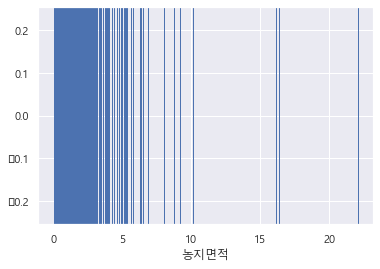

In [11]:
sns.rugplot(x='농지면적',data=data,height=1)
print(data['농지면적'].quantile(0.99)) #2.5 이상의 농지면적 모두 이상치로 판단
print(data['농지면적'].quantile(0.01)) #0.04이하의 농지면적 모두 이상치로 판단

- 분위값 확인

In [12]:
data=data.query('0.04<농지면적<2.5') #해당 면적 이상치로 판단하고 삭제

# 합계 컬럼 이상치 제거

9.0
1.0
2     4276
5     1765
4     1720
1     1645
3     1171
6      736
9      442
7      205
8      180
10      24
12       7
11       5
13       1
Name: 합계, dtype: int64


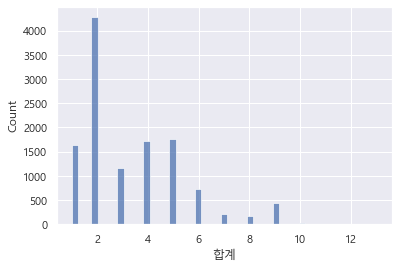

In [13]:
sns.histplot(x='합계',data=data)
print(data['합계'].quantile(0.99)) 
print(data['합계'].quantile(0.01)) 
print(data['합계'].value_counts()) #10 이상의 합계인원은 이상치로 판단하여 제거

In [14]:
data=data.query('합계<11') #합계 11미만의 값만 추출

## 4. 데이터 분할

In [15]:
# 작물 종류 기준 층화 추출 Train Test 비율 8:2
X=data.drop(columns=['합계']) #독립변수 Set
Y=data['합계'] #Target 변수 set

# Train, Test 분할
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.2,stratify=X['작물종류'],random_state=42)

# 2차 Train, Validation 분할
X_train, X_valid, Y_train, Y_valid=train_test_split(X_train,Y_train,test_size=0.2,stratify=X_train['작물종류'],random_state=42)

## 5. 정규화 및 라벨 인코딩

In [16]:
# 연속형 변수 정규화
min_max_scaler=MinMaxScaler()
for i in X_train.columns:
    if (X_train[i].dtypes!='object'):
        X_train[i]=min_max_scaler.fit_transform(X_train[[i]])
        X_valid[i]=min_max_scaler.transform(X_valid[[i]])
        X_test[i]=min_max_scaler.transform(X_test[[i]])
    else:
        pass

In [17]:
# 범주형 변수 라벨 인코딩
label_encoder=LabelEncoder()
for i in X_train.columns:
    if X_train[i].dtypes=='object':
        X_train[i]=label_encoder.fit_transform(X_train[i])
        X_valid[i]=label_encoder.transform(X_valid[i])
        X_test[i]=label_encoder.transform(X_test[i])
    else:
        pass

## 6. 모델 적용

- 주요 파라미터 설명

- gamma(값이 클수록 과적합을 방지해줌)=> [0,∞], 기본값=0=> 손실감소량에 대한 임계치임
ex) gamma가 2일때 loss가 2이하면 더 이상 트리 분할 X

- max_depth= Tree maximum depth 값
ex) 최대 가지 개수

- subsample= 데이터 샘플링 비율
ex) 0.8로 설정하면 각 트리가 학습할 때 전체 데이터의 80% 사용 => 과적합 방지
-------------------------------------------------------------------------------------------------------------


- 초기 파라미터
- dart부스터 학습률 0.05, 한트리의 최대 깊이 8, 반복 학습 횟수 200회로 진행
- XGBRegressor(booster='dart',learning_rate=0.05, max_depth=8, n_estimator=200)

-------------------------------------------------------------------------------------------------------------

- 파라미터 튜닝

- 학습률 0.05~0.01

- gamma 0~2

- max_depth 6~9

- subsample 0.5~1

- 반복수 100~300

### 6.1 초기 모델 적용

MAE: 1.29
MSE: 3.13
RMSE: 1.77
RMSPE: 132.56%


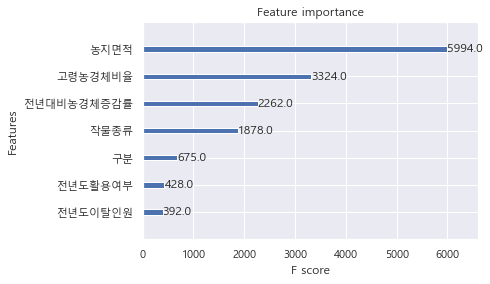

In [18]:
# XGB regressor 모델 구축
# dart부스터 학습률 0.05, 한트리의 최대 깊이 8, 반복 학습 횟수 200회로 진행

model_reg=XGBRegressor(booster='dart',learning_rate=0.05, max_depth=8, n_estimator=200)

# 모델 적용
model_reg.fit(X_train,Y_train)

# 변수 중요도 확인
plot_importance(model_reg)

# Test Data set 예측
pred=model_reg.predict(X_test)

# 인원 수 예측이기에 예측된 결과에 반올림 적용
pred=pd.DataFrame(pred,columns=['예측값'])
pred['예측값']=round(pred['예측값'],0)

#평가지표 추출
Evaluation_metric(Y_test,pred=pred['예측값'])

In [19]:
# Test data Set에 예측 결과 결합하여 지자체 기준으로 예측 정확도 확인
test_index=X_test.index.tolist()
data_test=data_real.loc[test_index]
data_test=data_test.reset_index()
data_test.drop(columns=['index'],inplace=True)
data_test['predict']=pred
result=data_test.groupby(['지자체명_시도','지자체명_시군구'])[['합계','predict']].sum().reset_index()
result_1=result.query('합계>10')

Evaluation_metric(result_1['합계'],pred=result_1['predict'])

MAE: 8.59
MSE: 148.24
RMSE: 12.18
RMSPE: 21.13%


### 6.2  Bayesian Optimization 파라미터 튜닝

In [20]:
# 목적 함수 정의
results = {
    'max_depth': [],
    'gamma': [],
    'subsample': [],
    'n_estimator': [],
    'learning_rate': [],
    'target': []  # 최적화 결과인 target 값 저장
}

def xgb_cv(max_depth, gamma, subsample, n_estimator, learning_rate):
    params = {
        'eval_metric': 'rmse',
        'max_depth': int(max_depth),
        'gamma': gamma,
        'subsample': subsample,
        'n_estimator': int(n_estimator),
        'learning_rate': learning_rate,
        'booster': 'dart'
    }
    
    # XGBoost Regressor 모델 초기화
    model_reg = xgb.XGBRegressor(**params)
    
    #model Train 학습
    model_reg.fit(X_train,Y_train)
    #model validation
    scores = -cross_val_score(model_reg, X_valid, Y_valid, cv=5, scoring='neg_mean_squared_error').mean()
    results['max_depth'].append(max_depth)
    results['gamma'].append(gamma)
    results['subsample'].append(subsample)
    results['n_estimator'].append(n_estimator)
    results['learning_rate'].append(learning_rate)
    results['target'].append(scores)
    return scores

# Bayesian Optimization 수행
xgbBO = BayesianOptimization(
    xgb_cv,
    {'max_depth': (8, 10),
     'gamma': (1, 2),
     'subsample': (0.85, 1.0),
     'n_estimator': (200, 300),
     'learning_rate': (0.04,0.05)}
)

# 최적화
xgbBO.maximize(init_points=10, n_iter=15)

idx_of_min=results['target'].index(min(results['target']))
min_pam={'booster':'dart'}
for key,value in results.items():
    if key=='target':
        pass
    else:
        if (key=='max_depth') or (key=='n_estimator'):
            min_pam[key]=int(round(value[idx_of_min],0))
        else:
            min_pam[key]=value[idx_of_min]
            
print(f'최종 파라미터는 {min_pam}입니다')

model_reg = xgb.XGBRegressor(**min_pam)
model_reg.fit(X_train,Y_train)

#예측값 
pred=model_reg.predict(X_test)
# 인원 수 예측이기에 예측된 결과에 반올림 적용
pred=pd.DataFrame(pred,columns=['예측값'])
#반올림
pred['예측값']=round(pred['예측값'],0)
#평가지표
print('농업경영체별 평가지표 결과')
Evaluation_metric(Y_test,pred=pred['예측값'])
print('-'*100)

test_index=X_test.index.tolist()
data_test=data_real.loc[test_index]
data_test=data_test.reset_index()
data_test.drop(columns=['index'],inplace=True)
#예측값
data_test['predict']=pred
result=data_test.groupby(['지자체명_시도','지자체명_시군구'])[['합계','predict']].sum().reset_index()
result_1=result.query('합계>10')
print('배정신청인원 10명 이상 시군구 단위 평가지표')
Evaluation_metric(result_1['합계'],pred=result_1['predict'])

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | 3.47      | 1.859     | 0.04277   | 9.197     | 219.0     | 0.8545    |
| 2         | 3.489     | 1.069     | 0.0443    | 9.58      | 273.4     | 0.8963    |
| 3         | 3.47      | 1.786     | 0.04003   | 8.185     | 201.2     | 0.9829    |
| 4         | 3.444     | 1.794     | 0.04658   | 8.234     | 277.4     | 0.8944    |
| 5         | 3.472     | 1.627     | 0.04393   | 9.912     | 215.4     | 0.9373    |
| 6         | 3.471     | 1.563     | 0.047     | 8.358     | 258.4     | 0.908     |
| 7         | 3.452     | 1.643     | 0.04236   | 9.938     | 288.8     | 0.9509    |
| 8         | 3.466     | 1.263     | 0.04942   | 8.385     | 226.4     | 0.9267    |
| 9         | 3.475     | 1.811     | 0.04538   | 8.693     | 219.8     | 0.9947    |
| 10        | 3.439     | 1.958     | 0.04815   | 8.45

# 6.3 OPTUNA 라이브러리 활용 파라미터 튜닝

In [21]:
def objective(trial):
    params={
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth',8,10), #8~10 정수중 택 1
        'gamma': trial.suggest_loguniform('gamma',1,2),
        'subsample': trial.suggest_categorical('subsample',[0.8,0.85,0.90,0.95,1]),
        'n_estimator': trial.suggest_int('n_estimator',200,400),
        'learning_rate': trial.suggest_float('learning_rate',0.03,0.05),
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),                                        
    }
    # 학습 모델 생성
    model_reg=xgb.XGBRegressor(**params)
    
    #트레인 셋 학습
    model_reg.fit(X_train,Y_train)
    
    #검증 데이터 셋으로 모델 검증
    score = mean_absolute_error(model_reg.predict(X_valid), Y_valid)
    return score

study=optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)

# 최적화된 파라미터 값 확인
best_params = study.best_params
print(best_params)

model_reg = xgb.XGBRegressor(**best_params)
model_reg.fit(X_train,Y_train)

#예측값 
pred=model_reg.predict(X_test)
# 인원 수 예측이기에 예측된 결과에 반올림 적용
pred=pd.DataFrame(pred,columns=['예측값'])
#반올림
pred['예측값']=round(pred['예측값'],0)
#평가지표
print('농업경영체별 평가지표 결과')
Evaluation_metric(Y_test,pred=pred['예측값'])
print('-'*100)

test_index=X_test.index.tolist()
data_test=data_real.loc[test_index]
data_test=data_test.reset_index()
data_test.drop(columns=['index'],inplace=True)
#예측값
data_test['predict']=pred
result=data_test.groupby(['지자체명_시도','지자체명_시군구'])[['합계','predict']].sum().reset_index()
result_1=result.query('합계>10')
print('배정신청인원 10명 이상 시군구 단위 평가지표')
Evaluation_metric(result_1['합계'],pred=result_1['predict'])

[I 2023-12-07 13:41:31,729] A new study created in memory with name: no-name-d06744db-fe74-4d28-a458-e7594997b8c9
[I 2023-12-07 13:41:34,101] Trial 0 finished with value: 1.3282535047976862 and parameters: {'max_depth': 10, 'gamma': 1.2412664368172812, 'subsample': 0.95, 'n_estimator': 365, 'learning_rate': 0.03326002083692385}. Best is trial 0 with value: 1.3282535047976862.
[I 2023-12-07 13:41:36,118] Trial 1 finished with value: 1.327677651803556 and parameters: {'max_depth': 9, 'gamma': 1.5680771345880404, 'subsample': 0.95, 'n_estimator': 356, 'learning_rate': 0.03479443408137288}. Best is trial 1 with value: 1.327677651803556.
[I 2023-12-07 13:41:38,225] Trial 2 finished with value: 1.323099244602166 and parameters: {'max_depth': 10, 'gamma': 1.961315061541749, 'subsample': 0.85, 'n_estimator': 261, 'learning_rate': 0.04736448065811888}. Best is trial 2 with value: 1.323099244602166.
[I 2023-12-07 13:41:40,326] Trial 3 finished with value: 1.3212637309851742 and parameters: {'max

{'max_depth': 9, 'gamma': 1.6771072349986085, 'subsample': 0.8, 'n_estimator': 266, 'learning_rate': 0.04674106017628428}
농업경영체별 평가지표 결과
MAE: 1.28
MSE: 3.1
RMSE: 1.76
RMSPE: 132.12%
----------------------------------------------------------------------------------------------------
배정신청인원 10명 이상 시군구 단위 평가지표
MAE: 8.25
MSE: 133.08
RMSE: 11.54
RMSPE: 20.47%


## 7. 결과 활용 및 해석

In [38]:
result_1['오차']=(result_1['predict']-result_1['합계'])/result_1['합계']

In [39]:
result_1

,지자체명_시도,지자체명_시군구,합계,predict,오차
0,강원도,삼척시,48,46.0,-0.041667
1,강원도,양구군,288,295.0,0.024306
2,강원도,영월군,44,49.0,0.113636
3,강원도,원주시,16,7.0,-0.562500
4,강원도,인제군,184,197.0,0.070652
...,...,...,...,...,...
110,충청북도,음성군,163,141.0,-0.134969
111,충청북도,제천시,23,40.0,0.739130
112,충청북도,진천군,102,105.0,0.029412
113,충청북도,청주시,46,57.0,0.239130


In [55]:
조치사항=[]
for i in result_1.index:
    if abs(result_1.loc[i,'오차']) <= 0.1:
        조치사항.append('현행유지')
    elif result_1.loc[i,'오차']>0.1:
        조치사항.append('배정감축')
    elif result_1.loc[i,'오차']<-0.1:
        조치사항.append('추가배정')

        
result_1['조치사항']=조치사항
result_1.to_csv('최종예측 결과_XGBoost.csv',encoding='EUC-KR')